<a href="https://colab.research.google.com/github/iciromaco/Semi3A/blob/master/L5/EdgeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# エッジ検出
OpenCVのエッジ検出フィルタについては、[ここ](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_gradients/py_gradients.html)を見よ

# ソーベルフィルタ
## **cv2.Sobel(画像,結果の格納型,x,y,ksize=3)**

微分（＝差分）とガウシアンフィルタを組み合わせたエッジ検出フィルタ

##ソーベルフィルタ（カーネルサイズ３の場合）

||||
|-|-|-|
|-1|0|1|
|-2|0|2|
|-1|0|1|

|x方向|
|-|

||||
|-|-|-|
|-1|-2|-1|
|0|0|0|
|1|2|1|

|y方向|
|-|

-1 と 1 、-2 と 2 は　右‐左　の計算を意味する。つまり差＝変化量を意味する。

微分という操作はデジタルではただの引き算となる。

1,2,1 はガウス分布

カーネルサイズを大きくすると、1,2,4,2,1 という風に、中央の重みが大きく、離れるにしたがって重みが小さくなる（ガウス分布＝正規分布）

### **結果の格納型**
元の画像は符号なし整数であるが、微分した結果は実数になるのでフローティング型を指定する必要がある。

**cv2.CV_32F**  
**cv2.CV_64F**

などを使う。

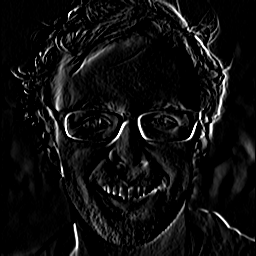

x方向のSobelフィルタの適用結果


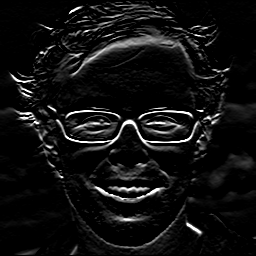

y方向のSobelフィルタの適用結果


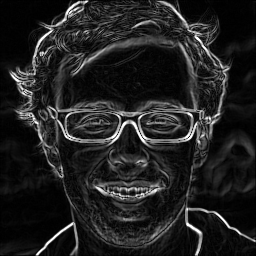

エッジ強度分布


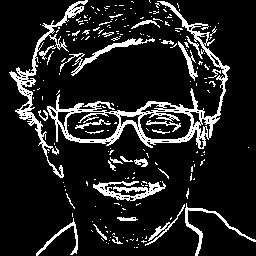

エッジ画像


In [1]:
import cv2
from google.colab.patches import cv2_imshow

#入力画像の読み込み（グレイスケール）
gry = cv2.imread('prof.png',0)
 
#Sobelフィルタでx方向のエッジ検出
sobelx = cv2.Sobel(gry,cv2.CV_64F,1,0) #1,0はｘ方向微分を意味する
 
#x方向のエッジ検出結果表示
cv2_imshow(sobelx)
print("x方向のSobelフィルタの適用結果")
 
#Sobelフィルタでy方向のエッジ検出
sobely = cv2.Sobel(gry,cv2.CV_64F,0,1)
 
#y方向のエッジ検出結果表示
cv2_imshow(sobely) 
print("y方向のSobelフィルタの適用結果")
 
#8ビット符号なし整数変換
abs_sobelx = cv2.convertScaleAbs(sobelx) 
abs_sobely = cv2.convertScaleAbs(sobely)
 
#重み付き和
sobel_edge = cv2.addWeighted(abs_sobelx,0.5,abs_sobely,0.5,0) 

#エッジ検出結果表示
cv2_imshow(sobel_edge)
print("エッジ強度分布")

#２階調化
ret,edge = cv2.threshold(sobel_edge,0,255,cv2.THRESH_OTSU)

#エッジ検出結果表示
cv2_imshow(edge)
print("エッジ画像")

ｘ方向（横方向）に微分した場合には縦エッジ、ｙ方向（縦方向）に微分した場合は横エッジが得られることに注意せよ。

## abs_sobelx = cv2.convertScaleAbs(sobelx,alpha=1,beta=0) 

　int(｜データ＊ alpha ＋ beta｜) という計算により、データを８ビット符号なし整数化に変換する

## sobel_edge = cv2.addWeighted(abs_sobelx,0.5,abs_sobely,0.5,0) 

　２つの画像の重みづけ和　
　このプログラムでは、ｘ微分とｙ微分を ともに0.5の重みで加えている。

## ret,edge = cv2.threshold(sobel_edge,0,255,cv2.THRESH_OTSU)

　判別分析法による２階調化



# Canny エッジ検出

Sobel法に代表されるエッジ検出フィルタはエッジそのものではなく、エッジらしさを表す数値のみを出力する。

ある画素がエッジであるかどうかは、適当なしきい値を設定して２値化するなどして決めざるをえない。

実際にしきい値処理を施してみると、しきい値が高すぎて線の途切れが発生したり、逆にしきい値が低すぎて余計な線がたくさん出てしまったりし、ひとつのしきい値で思い通りの線画を得ることは難しい。


Cannyエッジ検出フィルタは、

*   エッジ強度ではなく、エッジかどうかのみを表す２値画像を出力する
*   ２つのしきい値により、なるべく連続するエッジを得る

という特徴を持つエッジ検出法である。

<img width="562" alt="canny" src="https://user-images.githubusercontent.com/24559785/81762839-9b89d580-9508-11ea-878d-f1b903ce03e1.png">

Canny 法は複数のステップで２階調の線画像を得る．

1. ガウシアンフィルタにより画像を平滑化する．ノイズの除去がその目的である  
2. Sobel のフィルタによりエッジ強度の勾配と方向を求める  
3. エッジ上の点では勾配方向に対して勾配の強さが極大となっているはずであるから，それ以外の点は除外する．
4. エッジの候補点のうち，パラメータmaxValよりも強度の強い点をエッジであると確定する   
5.すでにエッジであると確定している点に連続する点で，パラメータ minVal よりもエッジ強度の強い点もエッジに加える．この操作を再帰的に実行する

　たとえば，図１を原画像とするとエッジ強度は図２のようになる．図３は赤枠と青枠の部分を水平方向に見たとき，水平方向を横軸，エッジ強度を縦軸に取ったグラフである．たとえば，図３の緑のレベルをしきい値として図２を２階調化すると図４のような２値画像が得られる．赤枠部のエッジは中央部が途切れ，青枠部は中央部のみが検出される．

　図に示すmaxValとminValをパラメータとして指定したとすると，青部分はエッジ強度が弱く maxVal を超える点がないため，Canny法ではエッジではないと判断される．赤部分は左右の部分が maxVal を超えるため，ステップ４でエッジ点と確定する．中央部はそれらの点と連続しており，minVal よりも強度が強いため，ステップ５でエッジ点に追加される． 結果として，Canny法のエッジ検出結果は図５に示すように，赤枠部が横１線のラインとなり，青枠部分の弱いエッジは無視される．


---

maxValとminVal の調整はなかなかむつかしい。次のサイトの説明が実践的でわかりやすい。

-[cv2.Canny(): Canny法によるエッジ検出の調整をいい感じにする](https://qiita.com/Takarasawa_/items/1556bf8e0513dca34a19)

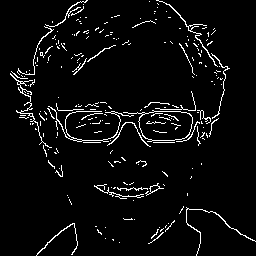

In [2]:
maxVal = 201 #@param {type:"slider", min:0, max:1000, step:1}
canny = cv2.Canny(gry, maxVal, maxVal)
cv2_imshow(canny)

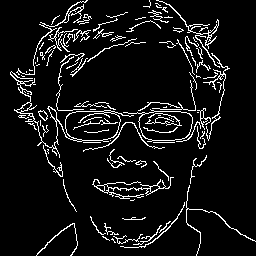

In [3]:
minVal = 92 #@param {type:"slider", min:0, max:300, step:1}
canny = cv2.Canny(gry, maxVal, minVal)
cv2_imshow(canny)